In [22]:
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import shared
import xarray as xr
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, ListedColormap

In [23]:
DPI = "figure"

In [24]:
# Define input/output paths
OUTPUTFIG = shared.DIR_FIGS / "Fig1_SLR_Fingerprints_Population.png"

# Fingerprint cmap
fp_colors = [
    (0, 0, 204),
    (51, 51, 255),
    (0, 102, 204),
    (0, 128, 255),
    (51, 153, 255),
    (102, 178, 255),
    (153, 204, 255),
    (204, 229, 255),
    (0, 204, 204),
]

fp_colors = [(r / 255, g / 255, b / 255) for r, g, b in fp_colors]
fp_bounds = np.arange(-0.2, 1.6 + 0.2, 0.2)
fp_cmap = ListedColormap(list(reversed(fp_colors)))
fp_norm = BoundaryNorm(boundaries=fp_bounds, ncolors=len(fp_colors))

# LS cmap
ls_colors = [
    (255, 255, 255, 0),  # transparent
    (253, 210, 165, 255),
    (253, 146, 67, 255),
    (223, 80, 5, 255),
    (127, 39, 4, 255),
]

ls_colors = [(r / 255, g / 255, b / 255, a / 255) for r, g, b, a in ls_colors]
ls_bounds = [0, 1e1, 1e2, 1e3, 1e4, 1e5]  # population density
ls_labels = ["0", "10", "100", "1,000", "10,000", ">10,000"]
ls_cmap = ListedColormap(ls_colors)
ls_norm = BoundaryNorm(ls_bounds, ncolors=len(ls_colors))

# CRS for plotting
proj = ccrs.Mollweide()

In [25]:
# Import LandScan 2020 data
ls20 = (
    rio.open_rasterio(shared.PATH_LANDSCAN, mask_and_scale=True)
    .squeeze(drop=True)
    .drop_vars("spatial_ref")
)

# 1km to 0.1° resample
target_res = 0.1
orig_res = float(np.absolute(ls20["y"][1] - ls20["y"][0]))
factor = int(np.round(target_res / orig_res))
ls20 = ls20.coarsen({"y": factor, "x": factor}, boundary="trim").sum()

ls20 = ls20.rio.write_crs("EPSG:4326")
ls20 = ls20.where(ls20 > 100).rename("population").to_dataset()


# Construct pop dens (ppl / km2)
def px_km2(lat, x_res=0.1, y_res=0.1, radius_km=6371):
    return (
        np.deg2rad(x_res) * np.deg2rad(y_res) * (radius_km**2) * np.cos(np.deg2rad(lat))
    )


ls20["area_km2"] = xr.DataArray(
    px_km2(ls20["y"]), coords={ls20["y"].dims[0]: ls20["y"]}, dims=[ls20["y"].dims[0]]
)
ls20["ppl_km2"] = ls20["population"] / ls20["area_km2"]

In [26]:
# Import SLR fingerprints
ais_grid = np.loadtxt(shared.PATH_SLR_IS_GRID_ANT_RAW)
gris_grid = np.loadtxt(shared.PATH_SLR_IS_GRID_GR_RAW)

# Define coordinates
ny, nx = ais_grid.shape
x = np.arange(nx)
y = np.arange(ny)

# Build xarray DataArray
ds = xr.DataArray(
    ais_grid, dims=("y", "x"), coords={"y": y, "x": x}, name="AIS_SLR"
).to_dataset()

ny, nx = gris_grid.shape
x = np.arange(nx)
y = np.arange(ny)

ds["GrIS_SLR"] = xr.DataArray(
    gris_grid,
    dims=("y", "x"),
    coords={"y": y, "x": x},
)

xres = 360 / nx
yres = 180 / nx

miny = -90 + yres / 2
maxy = 90 - yres / 2
minx = 0 + xres / 2
maxx = 360 - yres / 2

ys = np.linspace(maxy, miny, ny)
xs = np.linspace(minx, maxx, nx)

ds["x"] = xs
ds["x"] = ((ds["x"] + 180) % 360) - 180
ds = ds.sortby("x")

ds["y"] = ys
ds = ds.sortby("y")
ds = ds.rio.write_crs("EPSG:4326")

# Resample to finer grid for plotting
ds_sm = ds.interp(
    x=np.linspace(ds.x.min().item(), ds.x.max().item(), ds.sizes["x"] * 3),
    y=np.linspace(ds.y.min().item(), ds.y.max().item(), ds.sizes["y"] * 3),
    method="linear",  # or 'cubic' for smoother
)
ds_sm = ds_sm.rolling(x=10, y=10, center=True).mean()

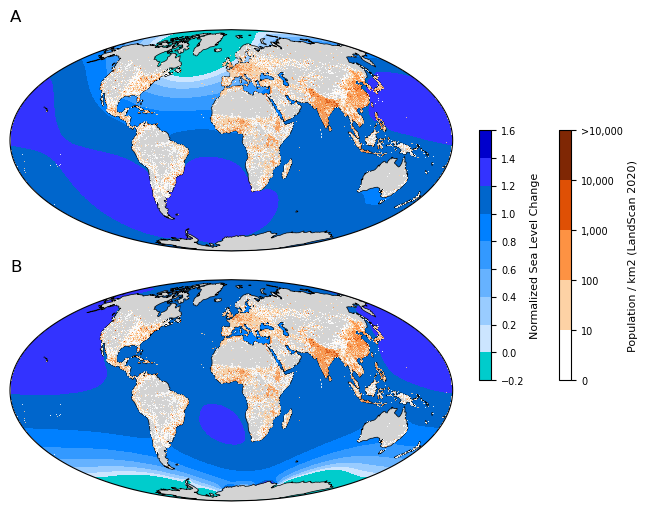

In [29]:
# Set up projection and figure
pop = ls20.ppl_km2

proj = ccrs.Mollweide()
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 5),
    subplot_kw={"projection": proj},
    layout="constrained",
)

# Plot both fingerprints
for v, ax, plab in zip(["GrIS_SLR", "AIS_SLR"], axs, ["A", "B"]):
    ax.set_title(plab, loc="left", fontsize=12)

    # Base FP data
    fp1 = ax.pcolormesh(
        ds_sm["x"],
        ds_sm["y"],
        ds_sm[v],
        cmap=fp_cmap,
        norm=fp_norm,
        transform=ccrs.PlateCarree(),
        zorder=0,
    )

    # population
    ls1 = ax.pcolormesh(
        pop["x"],
        pop["y"],
        pop,
        cmap=ls_cmap,
        norm=ls_norm,
        transform=ccrs.PlateCarree(),
        alpha=0.8,
        zorder=2,
    )

    ax.add_feature(
        cfeature.LAND, facecolor="lightgrey", edgecolor="k", linewidth=0.5, zorder=1
    )

# Color Bar for SLR footprint
cax = fig.add_axes([0.81, 0.25, 0.015, 0.5])
sm = ScalarMappable(norm=fp_norm, cmap=fp_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label("Normalized Sea Level Change", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# Color Bar for Population
cax = fig.add_axes([0.91, 0.25, 0.015, 0.5])
sm = ScalarMappable(norm=ls_norm, cmap=ls_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label("Population / km2 (LandScan 2020)", fontsize=8)

tick_values = ls_bounds
tick_labels = ls_labels
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=7)

# Save fig (png and pdf)
save_kwargs = {"dpi": DPI, "bbox_inches": "tight"}
fig.savefig(OUTPUTFIG, **save_kwargs)
fig.savefig(OUTPUTFIG.parent / (OUTPUTFIG.stem + ".pdf"), **save_kwargs)